# Dynamic Rupture modelling for the 2017 Botswana M 6.5 Intraplate Earthquake

### Hongyi Su, BEng., BSc., MSc Candidate at LMU Munich and TUM, Germany


The 2017 Botswana earthquake was a magnitude 6.5 earthquake which occurred in the Central District of Botswana. It is the second largest earthquake recorded in Botswana next to the 6.7 magnitude earthquake in Maun which occurred in 1952. The earthquake which happened at 19:40, local time according to the US Geological Survey. 

More info: https://earthquake.usgs.gov/earthquakes/eventpage/us10008e3k/executive

<img src="https://images.moneycontrol.com/static-mcnews/2017/04/earthquake.jpg?impolicy=website&width=770&height=431"/>

Photo credit © e-Eighteen.com Ltd.

#### Time: 2017-04-03 17:40:18 (UTC), Location: 22.678°S 25.156°E, Depth: 29.0 km 

In [113]:
import os
import numpy as np
from obspy import read, Trace
from obspy.clients.fdsn.header import FDSNException
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import xml.etree.ElementTree as ET
import pyproj
import matplotlib.pyplot as plt
from scipy.io import savemat #for save obspy object as matlab format

## SAVE Synthetics in MAT Format


In [106]:
def ReadSeisSolSeismogram(folderprefix, idst, coords_only=False):
    """READ seissol receiver nb i"""
    mytemplate = "%s-receiver-%05d*" % (folderprefix, idst)
    f = os.popen("ls " + mytemplate)
    now = f.read()
    myfile = now.strip()
    if myfile == "":
        return False
    fid = open(myfile)
    fid.readline()
    variablelist = fid.readline()[11:].split(",")
    variablelist = np.array([a.strip().strip('"') for a in variablelist])
    xsyn = float(fid.readline().split()[2])
    ysyn = float(fid.readline().split()[2])
    zsyn = float(fid.readline().split()[2])
    if coords_only:
        return [xsyn, ysyn, zsyn]
    synth = np.loadtxt(fid)
    fid.close()
    return ([xsyn, ysyn, zsyn], variablelist, synth)
def CreateObspyTraceFromSeissolSeismogram(station, variablelist, synth, starttime):
    """Load synthetics into an obspy stream"""
    st_syn = read()
    st_syn.clear()
    xyz = "ENZ"
    uvw = "uvw"
    for i in range(0, 3):
        j = np.where(variablelist == uvw[i])[0]
        try:
            j = j[0]
        except IndexError:
            print("uvw[i] = %s not in variable list:" % (uvw[i]), variablelist)
            raise ("uvw[i] not found in variable list")
        tr = Trace()
        # tr.stats.station = station +'.'+ xyz[i]
        tr.stats.station = station
        tr.stats.channel = xyz[i]
        tr.data = synth[:, j]
        tr.stats.delta = synth[1, 0] - synth[0, 0]
        tr.stats.starttime = starttime
        st_syn.append(tr)
    return st_syn


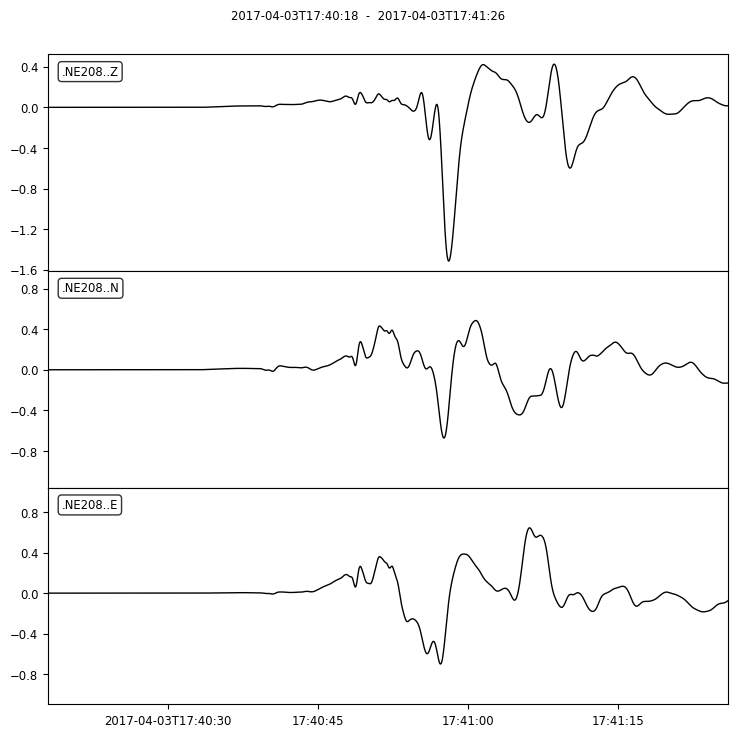

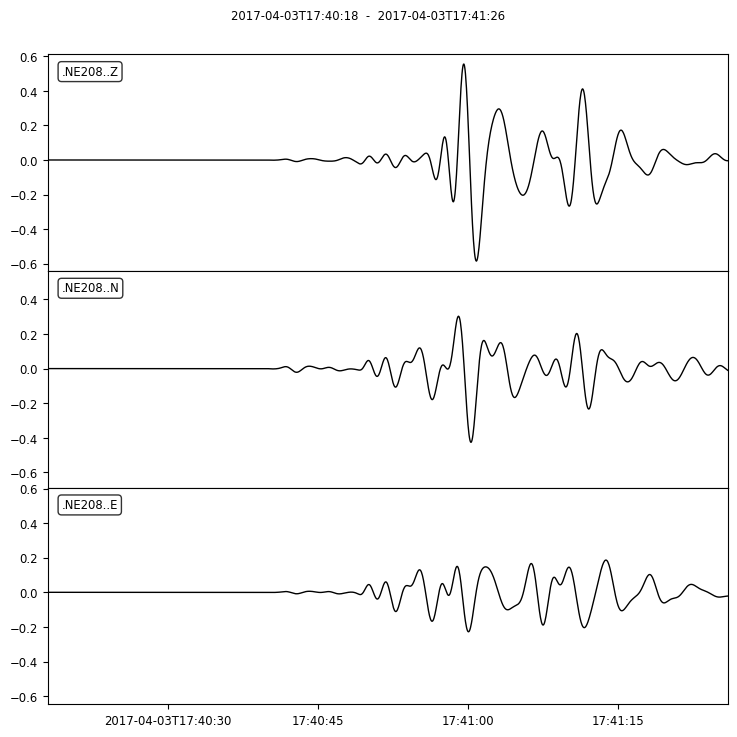

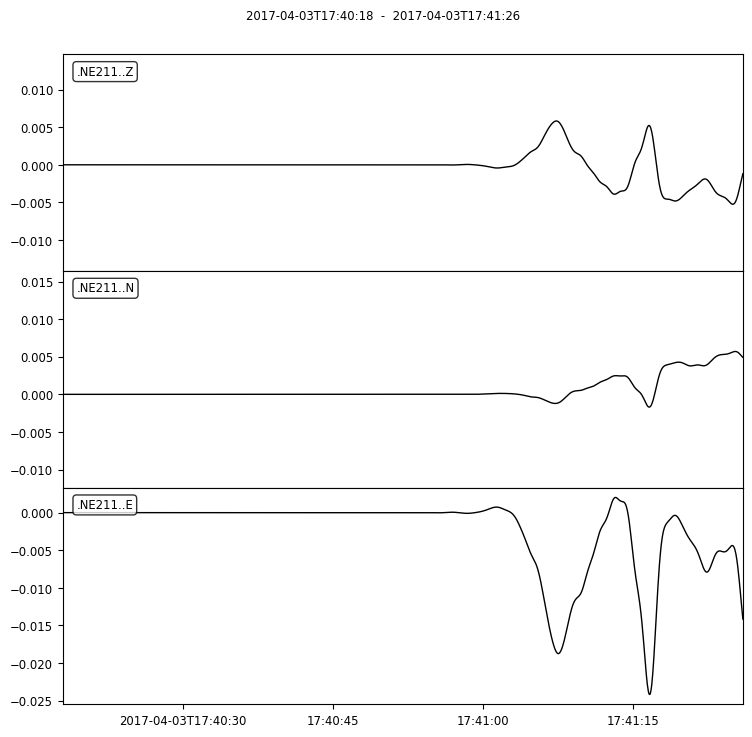

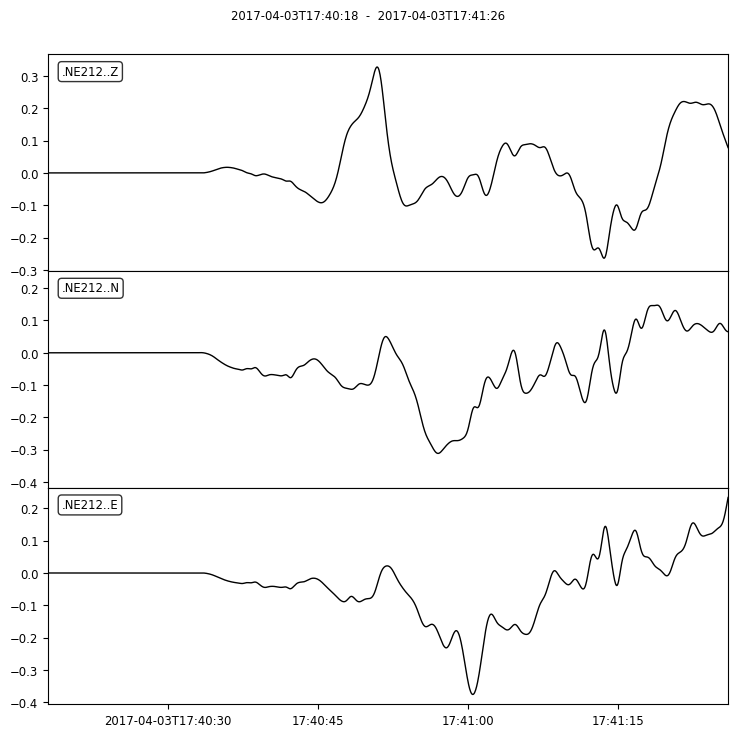

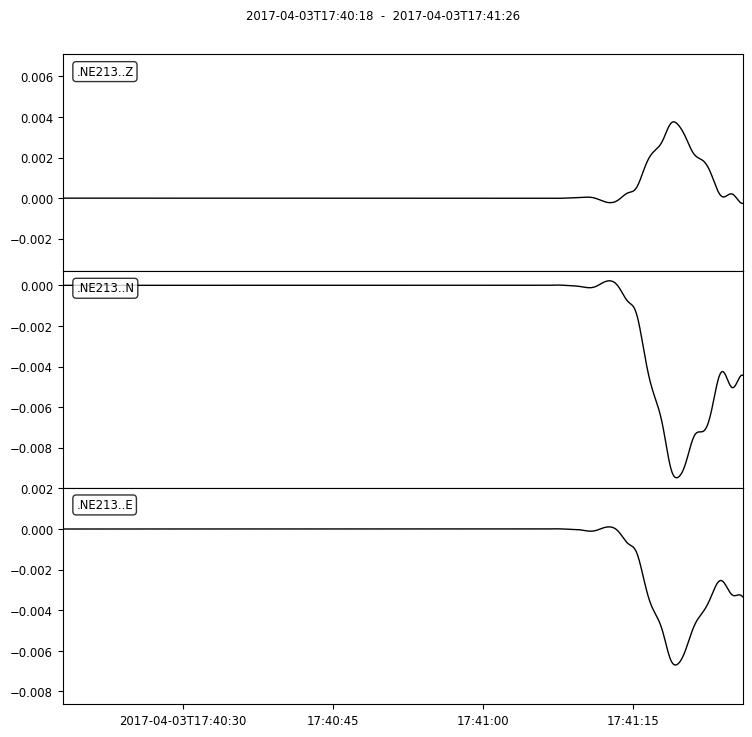

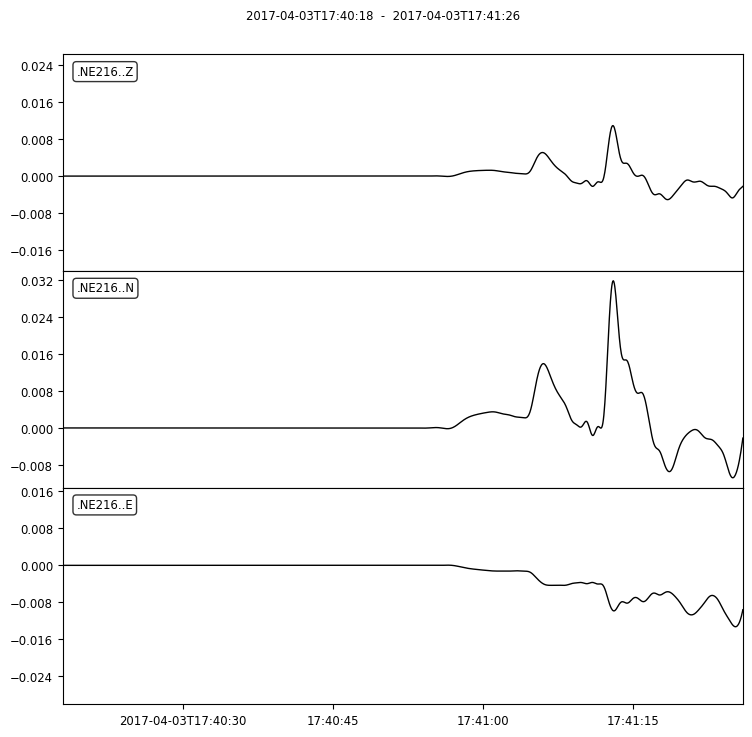

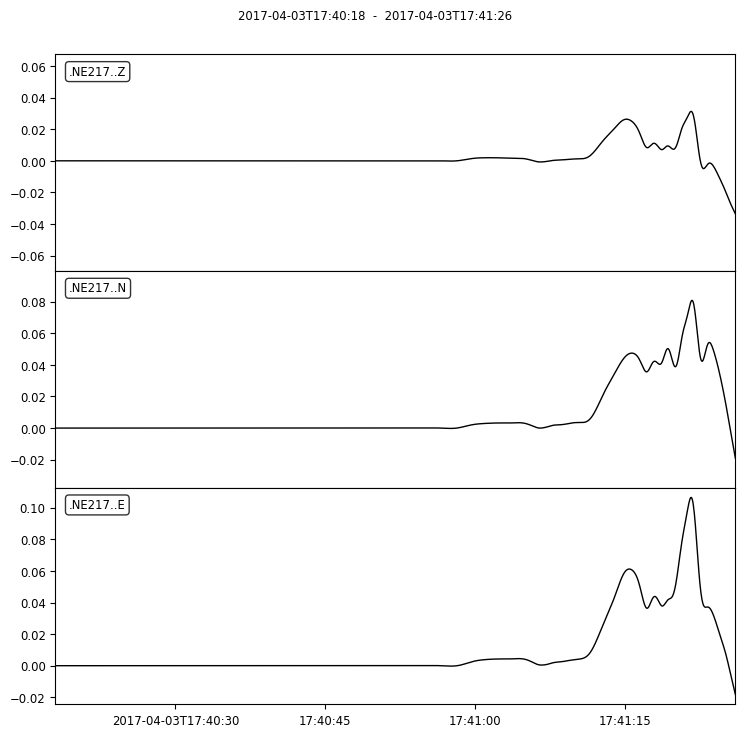

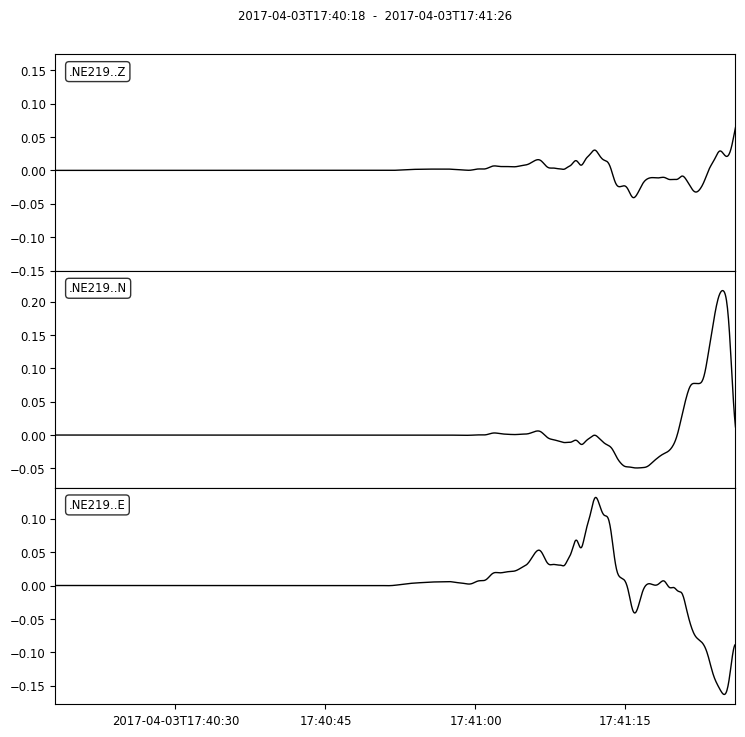

In [18]:
#folderprefix = "../syn/botswana_model_5_l4_60s"
#folderprefix = "../syn/botswana_model_700kmr6_new"
#folderprefix = "../syn/model_095_1200km"
folderprefix = "../syn/model_062_1200km"
#folderprefix = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)

idst = [3,5,6,7,8,9,11]
sta = ["NE208", "NE211", "NE212", "NE213", "NE216", "NE217", "NE219"]

for i,j in enumerate(idst):
    [my_syn, variable, data] = ReadSeisSolSeismogram(folderprefix, j, coords_only=False)
    station = sta[i]
    my_trace = CreateObspyTraceFromSeissolSeismogram(station,variable, data, starttime )
    my_trace.plot();
    my_trace2=my_trace.copy()
    my_trace2.detrend()
    my_trace3=my_trace2.copy()
    my_trace3.filter("bandpass", freqmin=0.2, freqmax=0.6, corners=4)
    my_trace3.plot();
    for i, tr in enumerate(my_trace3):
        mdict = {k: str(v) for k, v in tr.stats.items()}
        mdict['data'] = tr.data
        #savemat("../syn/syn_filtered/Model-062_1200km-" + str(station) + "_"  + str(i) + ".mat", mdict)

# SAVE Observational in MAT Format


NR_station_list = ["NE201", "NE208","NE209","NE211","NE212", "NE213", "NE216","NE217","NE218","NE219", "NE220"]   
#NE201 NA
#NE208 YES "clipped"
#NE209 NA
#NE211 YES 
#NE212 YES
#NE213 YES
#NE216 YES
#NE217 YES 
#NE218 NA
#NE219 YES "clean" 
#NE220 NA
ZT_station_list = ["MARA","MRCO","NHAM","NYAT"]
#MARA NA
#MRCO NA
#NHAM NA
#NYAT NA

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

In [20]:
#2017-4-3T17:40:18
t = UTCDateTime(2017, 4, 3, 17, 40, 18)
lon = 25.1558
lat = -22.6784
client = Client('IRIS')
inventory = client.get_stations(
    starttime=t-100, endtime=t+100,
    longitude=lon, latitude=lat, maxradius=7,
    matchtimeseries=None)
#print(inventory)

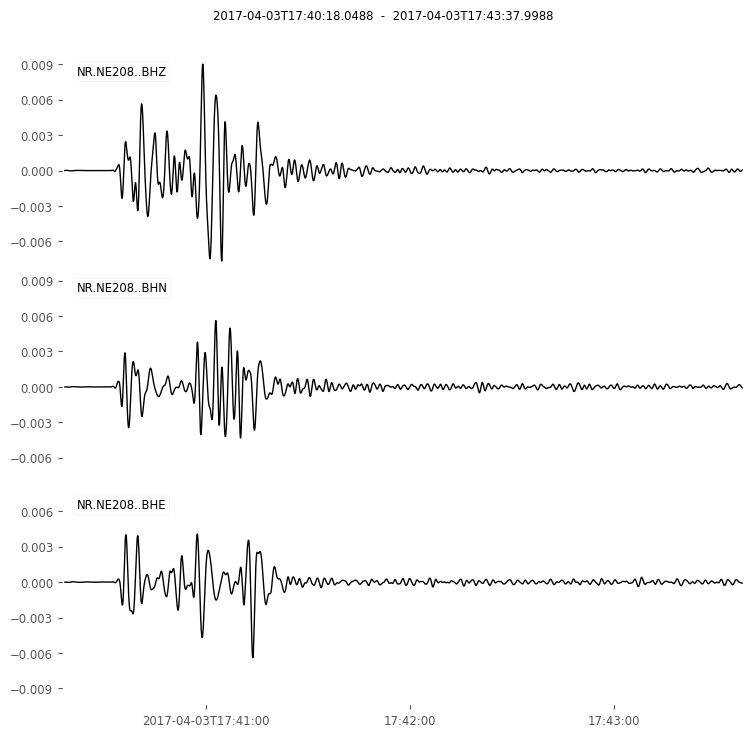

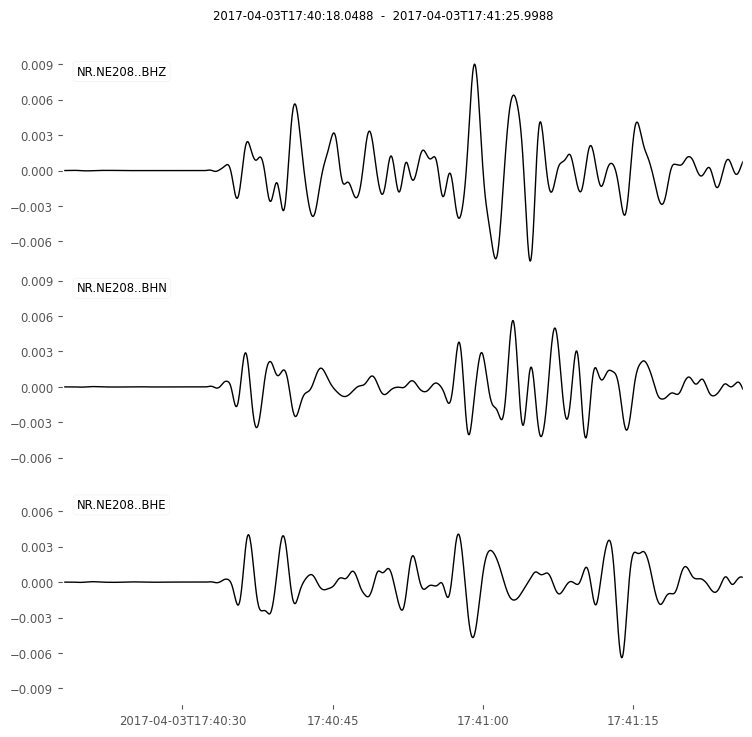

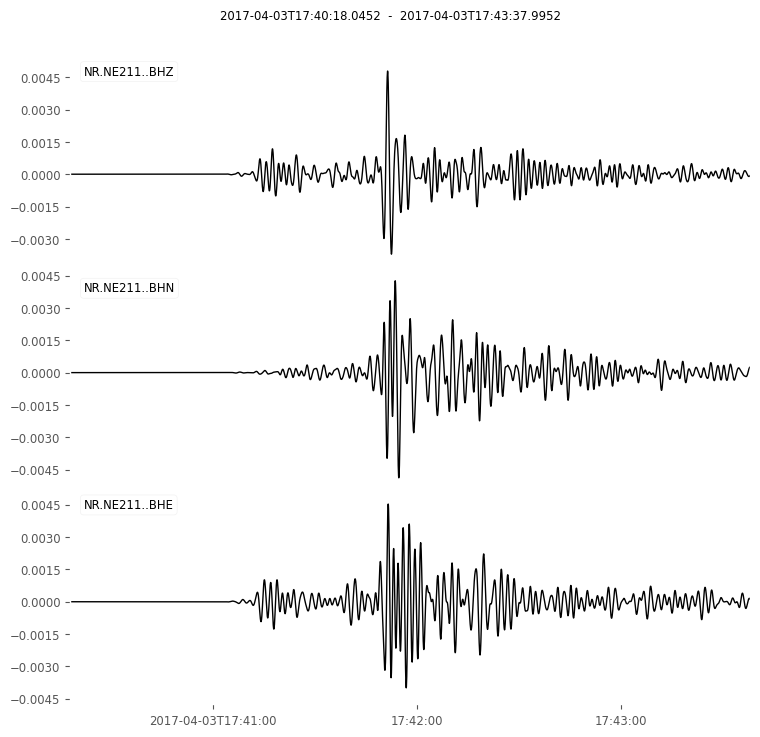

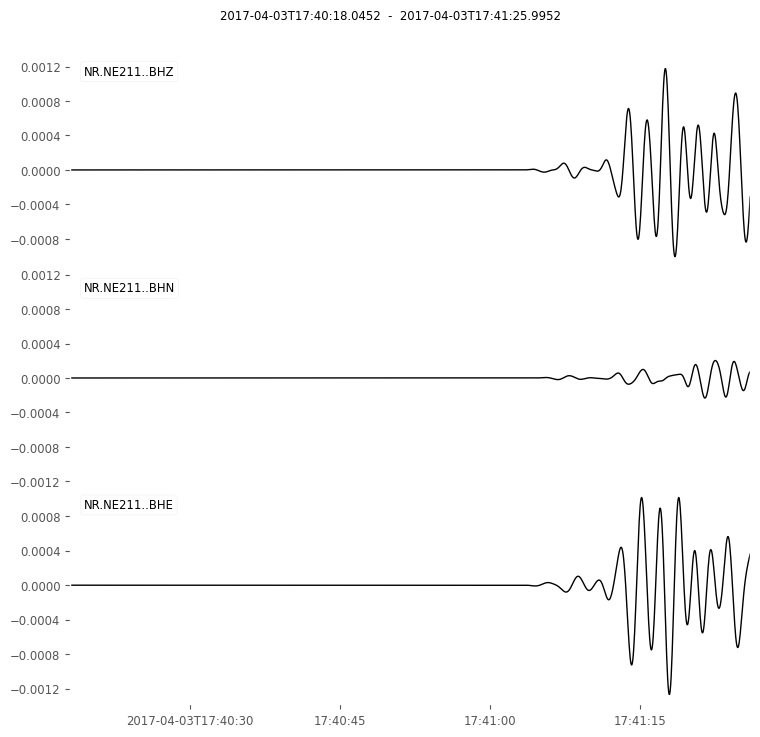

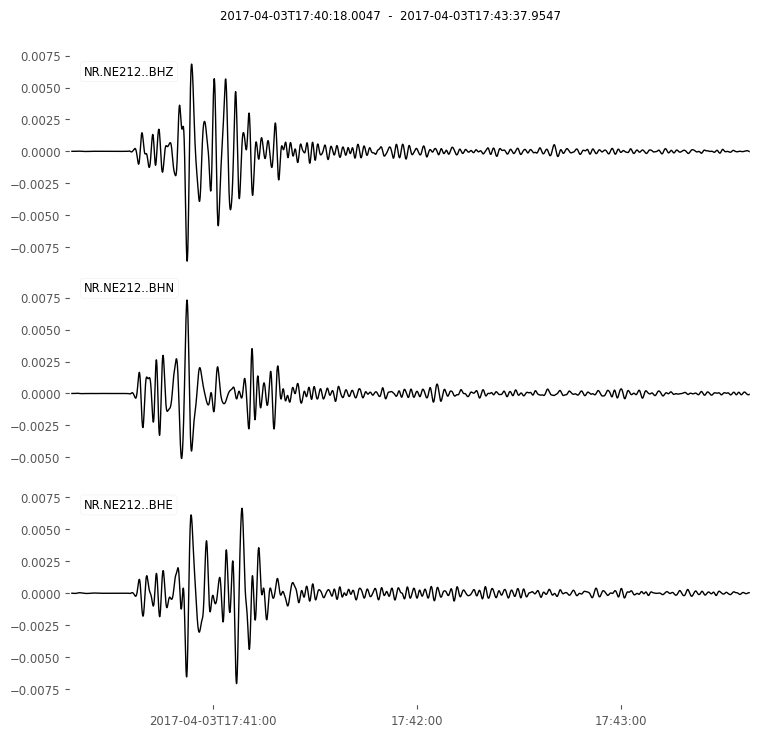

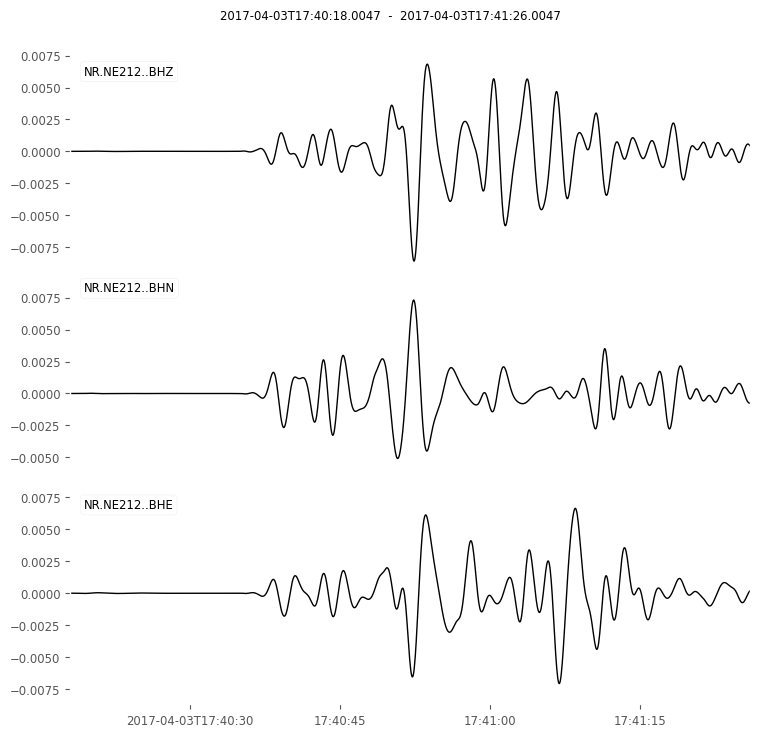

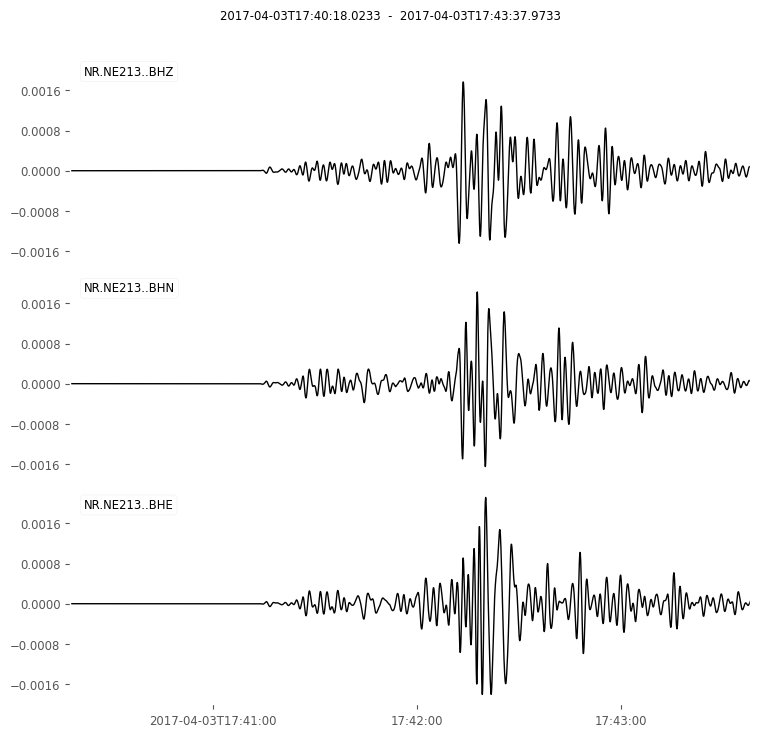

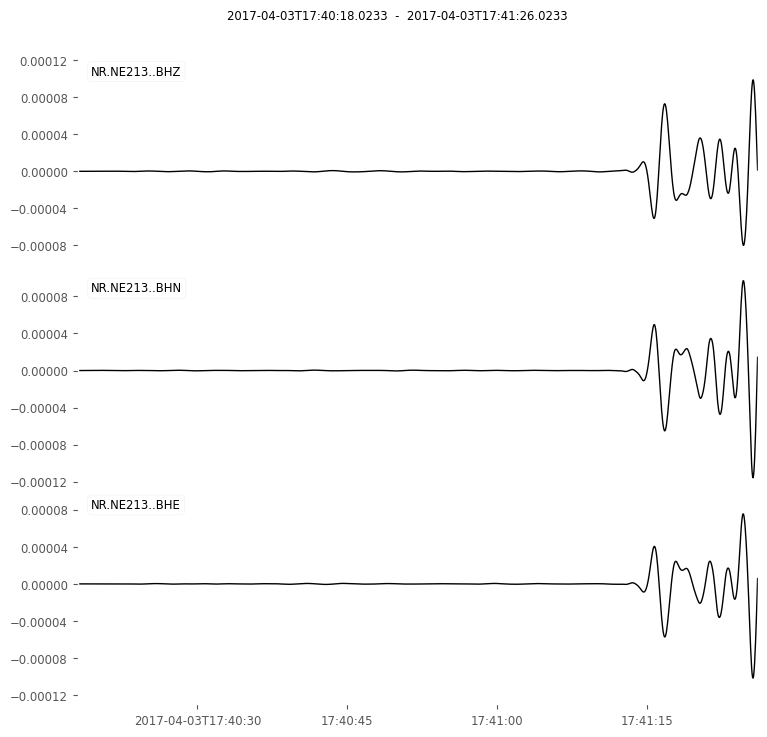

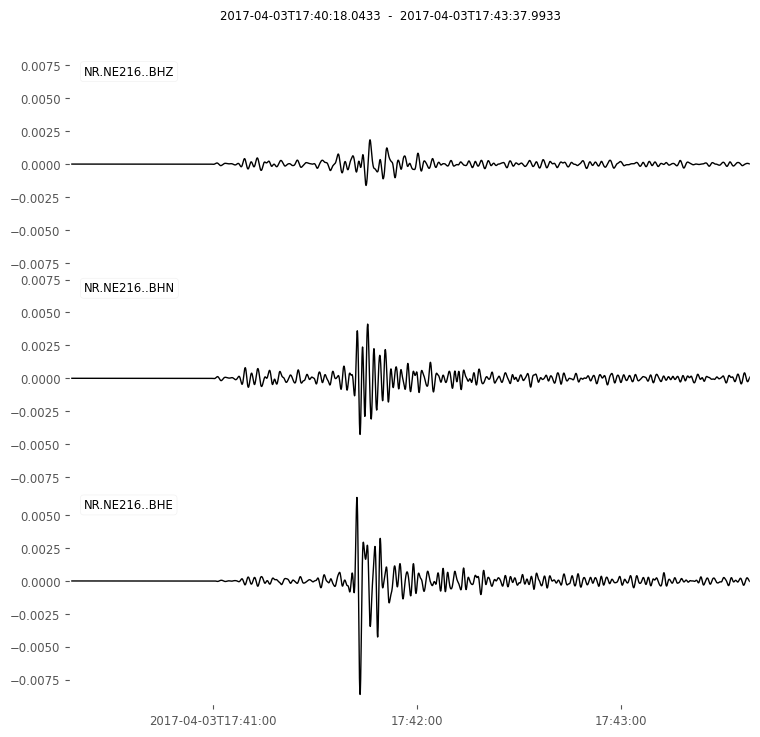

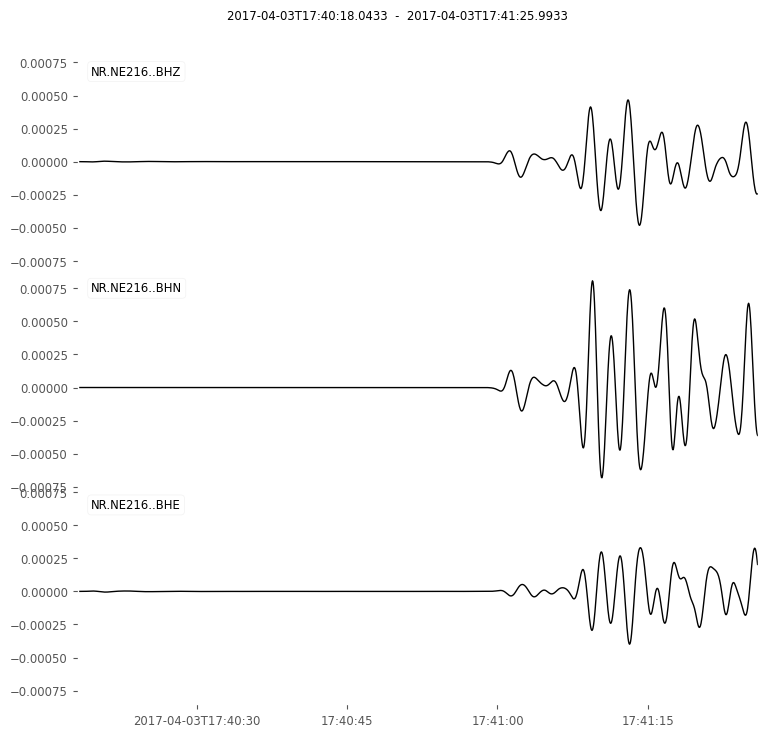

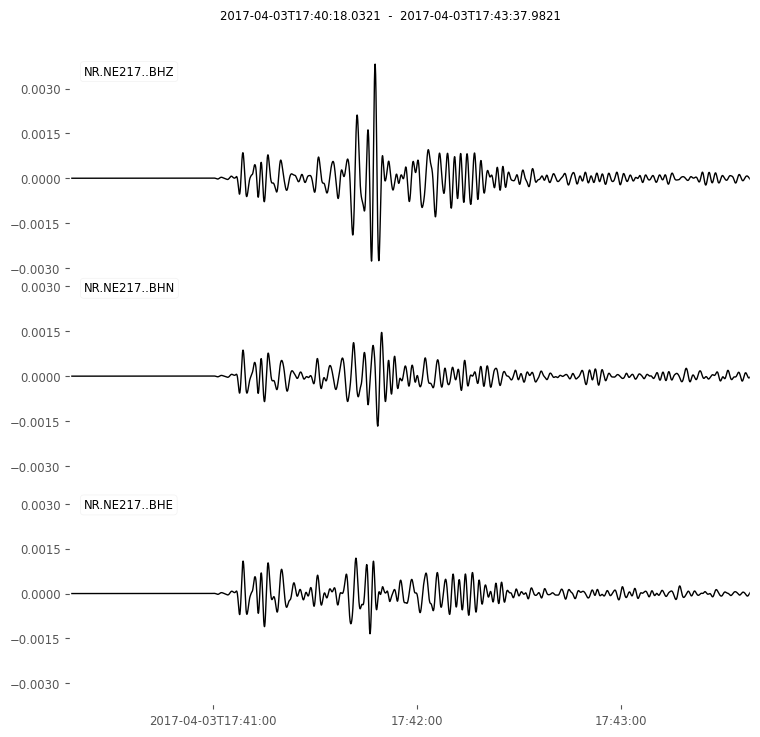

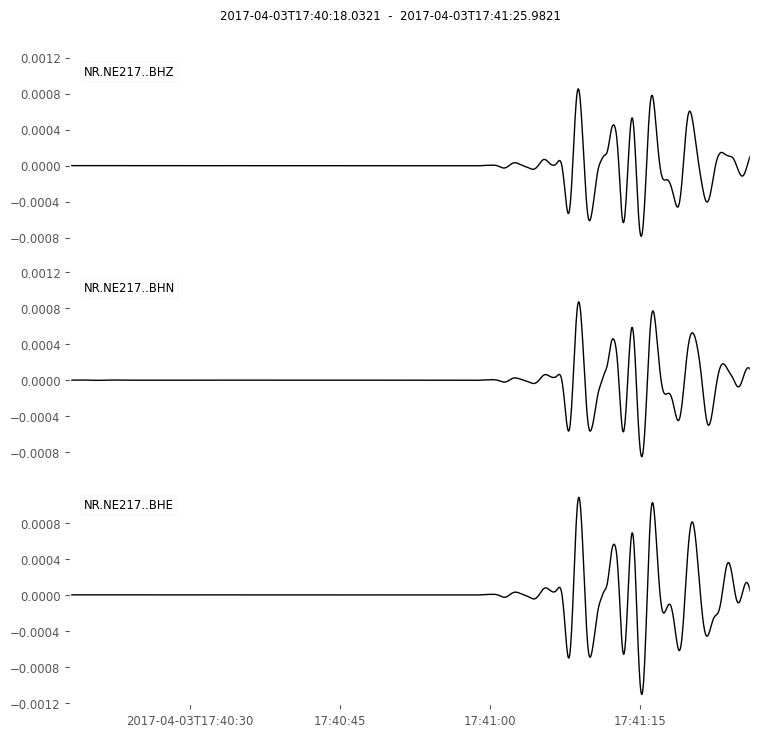

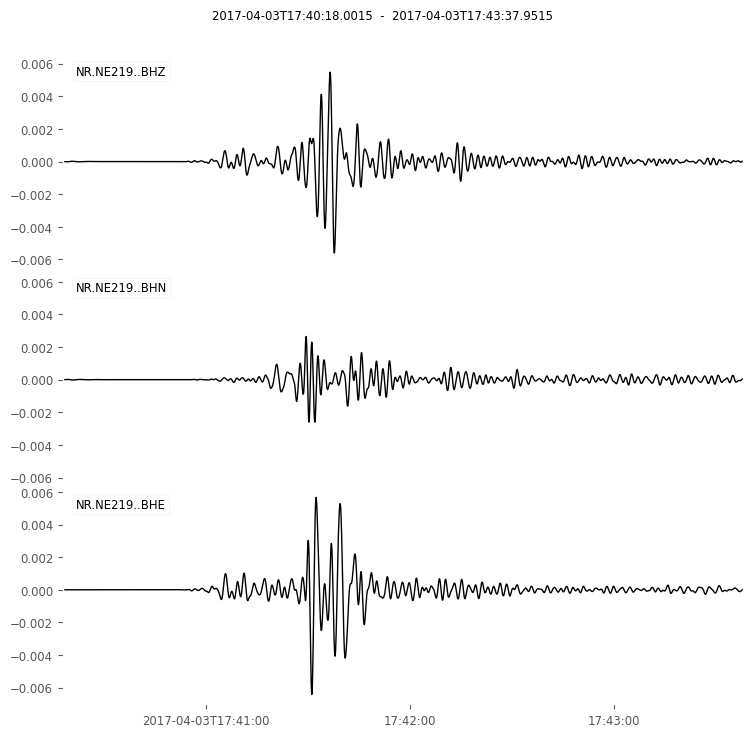

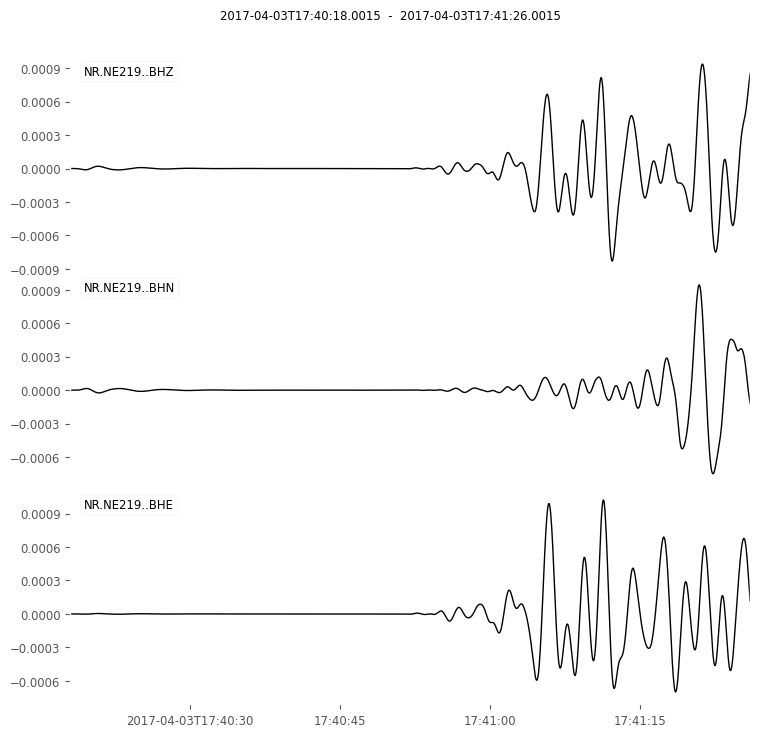

In [21]:
#Start here, change variable net and sta to download data from desired station
net = "NR"
#sta = "NE208"

List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
for sta in List:
    st = client.get_waveforms(net, sta, "*", "BH*", t, t+200, attach_response=True)
    st.remove_response(output="VEL")
    st2=st.copy()
    st2.detrend()
    st3=st2.copy()
    st3.filter("bandpass", freqmin=0.2, freqmax=0.6, corners=4)
    st3.plot()
    st4=st3.copy()
    st4.trim(t,t+68)
    st4.plot()
#save data in mat format
#BHZ - 0
#BHN - 1
#BHE - 2
    for i, tr in enumerate(st4):
        mdict = {k: str(v) for k, v in tr.stats.items()}
        mdict['data'] = tr.data
       #savemat("obs_filtered/data_68s_filtered-" + str(sta) + "_" + str(i) +".mat", mdict)
        

# PLOT them TOGETHER

In [46]:
%matplotlib inline
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

In [107]:
def plot_my_data(syn_data, obs_data, sta):
    #BHZ
    tr1_z = obs_data[0]
    tr2_z = syn_data[0]
    fig = plt.figure()
    ax = fig.add_subplot(6, 3, 1)
    ax.plot(tr1_z.times("matplotlib"), tr1_z.data, "b-")
    plt.title(sta + "_BHZ")
    ax.xaxis_date()
    ax = fig.add_subplot(6, 3, 4)
    ax.plot(tr2_z.times("matplotlib"), tr2_z.data, "r-")
    ax.xaxis_date()
    fig.autofmt_xdate()
    #BHN
    tr1_n = obs_data[1]
    tr2_n = syn_data[1]
    ax = fig.add_subplot(6, 3, 2)
    ax.plot(tr1_n.times("matplotlib"), tr1_n.data, "b-")
    plt.title(sta + "_BHN")
    ax.xaxis_date()
    ax = fig.add_subplot(6, 3, 5)
    ax.plot(tr2_n.times("matplotlib"), tr2_n.data, "r-")
    ax.xaxis_date()
    fig.autofmt_xdate()
    #BHE
    tr1_e = obs_data[2]
    tr2_e = syn_data[2]
    ax = fig.add_subplot(6, 3, 3)
    ax.plot(tr1_e.times("matplotlib"), tr1_e.data, "b-")
    plt.title(sta + "_BHE")
    ax.xaxis_date()
    ax = fig.add_subplot(6, 3, 6)
    ax.plot(tr2_e.times("matplotlib"), tr2_e.data, "r-")
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.show()

def process_my_data(st, fmin, fmax, cor):
    st2=st.copy()
    st2.detrend()
    st3=st2.copy()
    st3.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=cor)
    st4=st3.copy()
    return st4

def plot_model(model_id,idst, net, List,starttime):
    for i,j in enumerate(idst):
        [my_syn, variable, data] = ReadSeisSolSeismogram(model_id, j, coords_only=False)
        station = List[i]
        syn_data = CreateObspyTraceFromSeissolSeismogram(station,variable, data, starttime )
        syn_data_filtered = process_my_data(syn_data, fmin, fmax, cor)
        obs_data = client.get_waveforms(net, station, "*", "BH*", t, t+200, attach_response=True)
        obs_data.remove_response(output="VEL") 
        obs_data_filtered = process_my_data(obs_data, fmin, fmax, cor)
        obs_data_filtered_trim = obs_data_filtered.copy()
        obs_data_filtered_trim.trim(t,t+68)       
        plot_my_data(syn_data_filtered, obs_data_filtered_trim, station)

## Model_095_1200km  $\gamma$ = 0.95

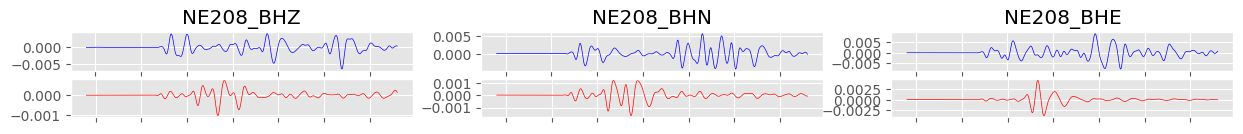

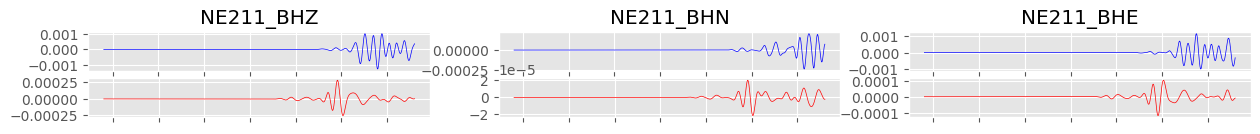

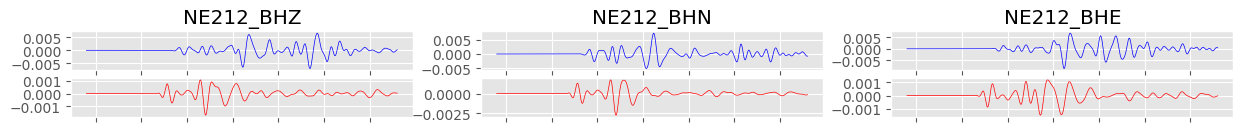

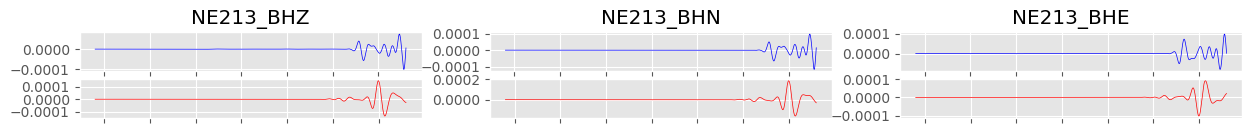

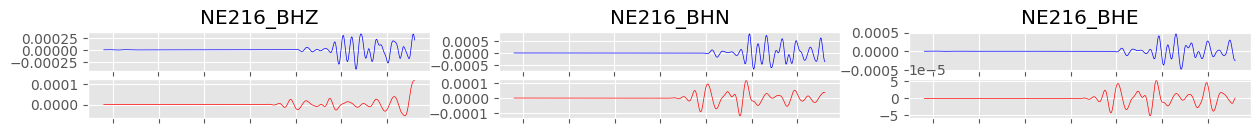

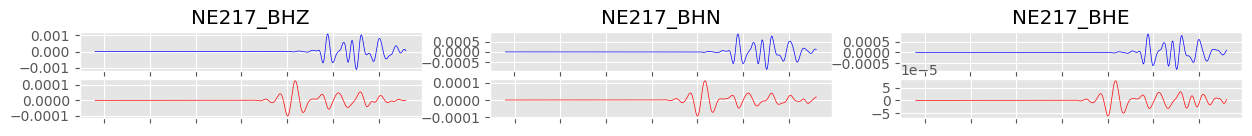

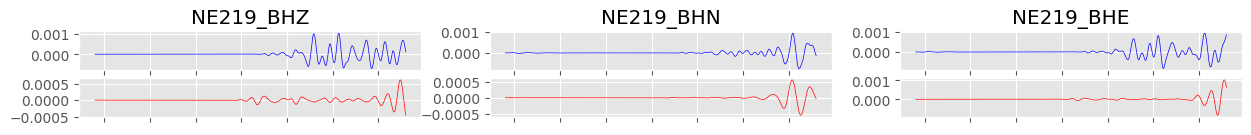

In [109]:
Model_095 = "../syn/model_095_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.2
fmax = 0.6
plot_model(Model_095, idst, net, List,starttime)

## Model_062_1200km  $\gamma$ = 0.62

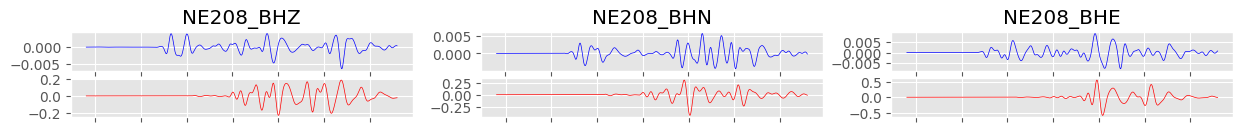

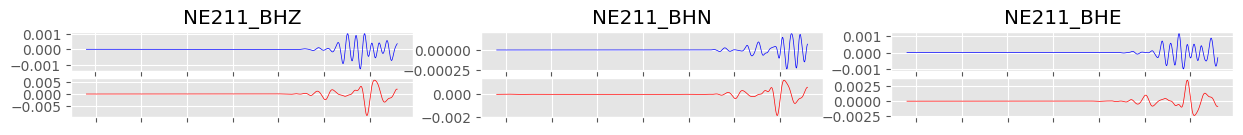

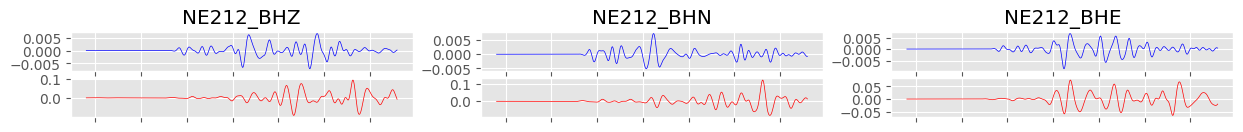

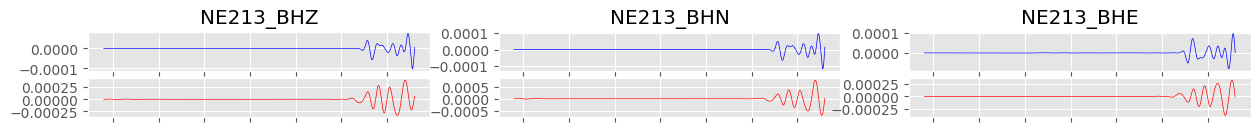

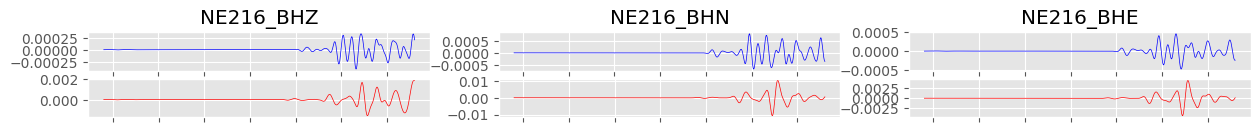

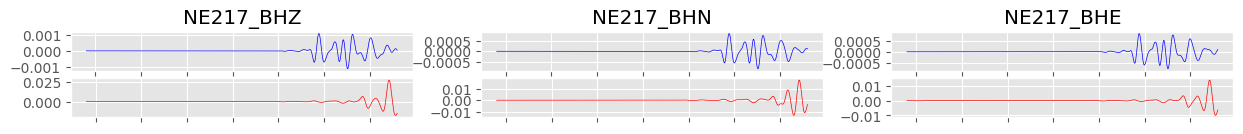

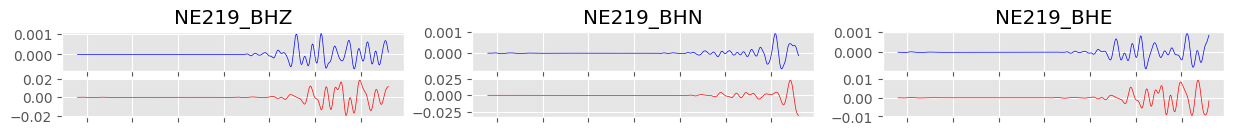

In [110]:
Model_062 = "../syn/model_062_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.2
fmax = 0.6
#Model_062
plot_model(Model_062, idst, net, List,starttime)

## Model_037_1200km  $\gamma$ = 0.37

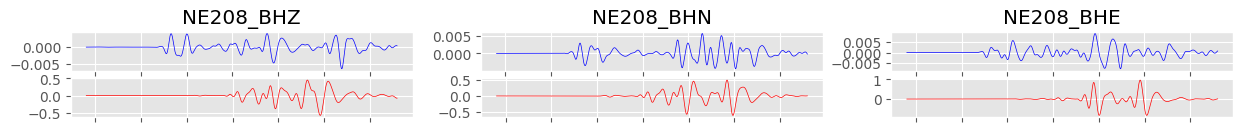

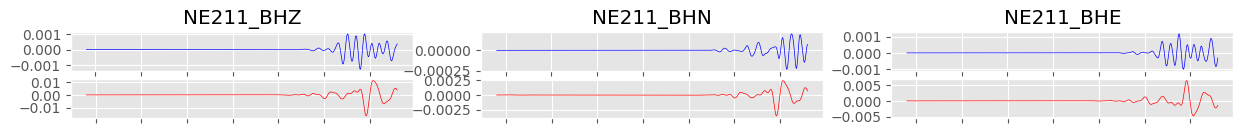

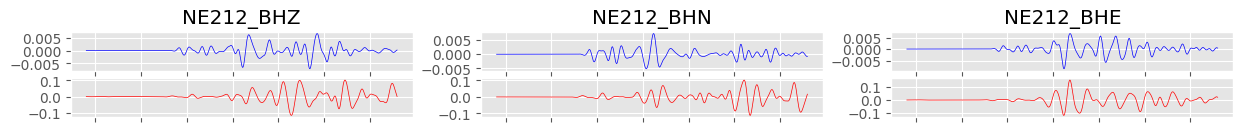

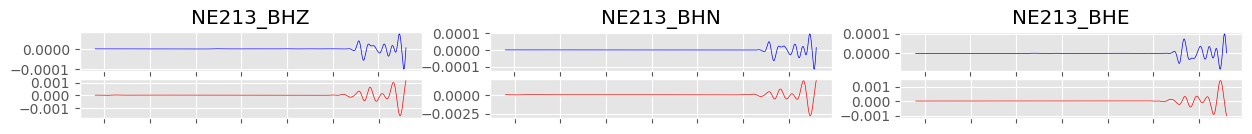

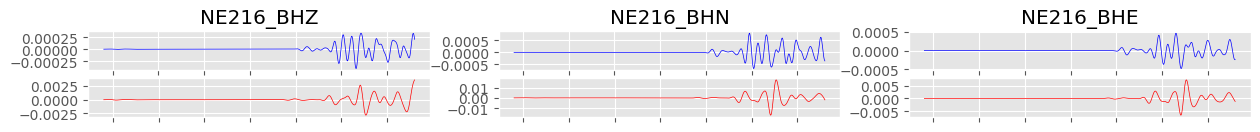

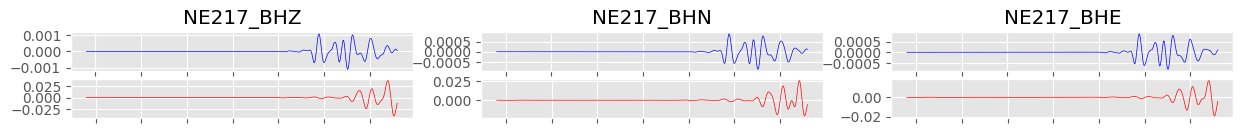

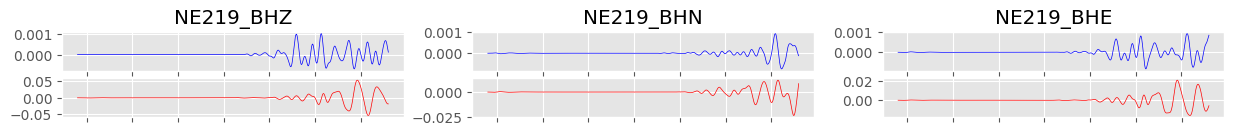

In [111]:
Model_037 = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.2
fmax = 0.6
#Model_062
plot_model(Model_037, idst, net, List,starttime)

## Try different frequency band
##### [0.01 - 0.2]

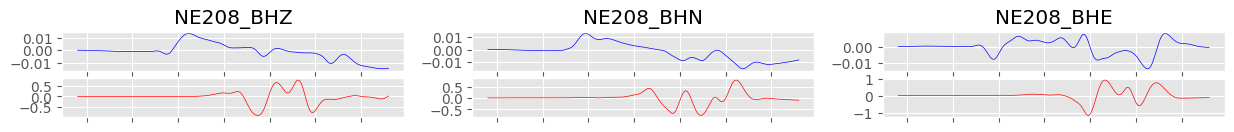

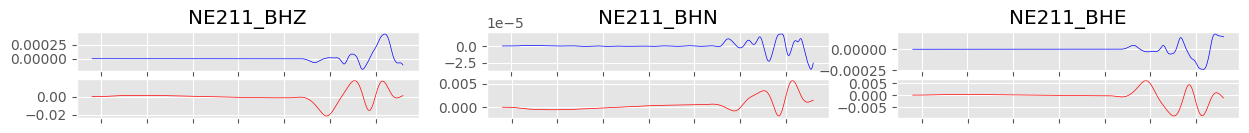

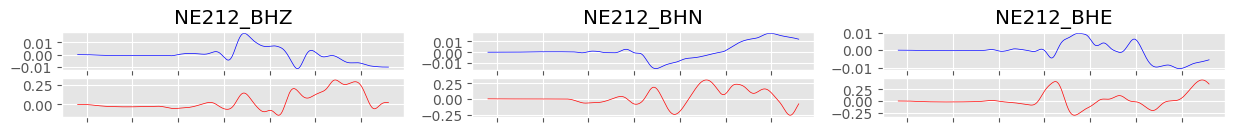

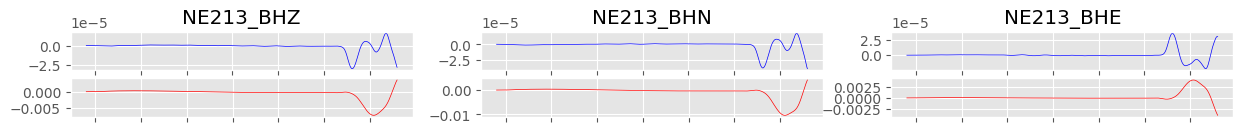

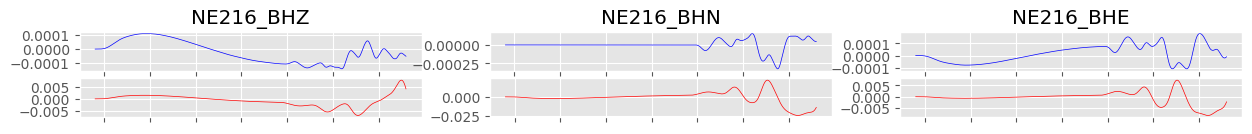

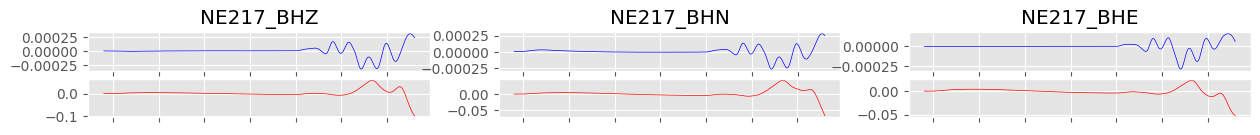

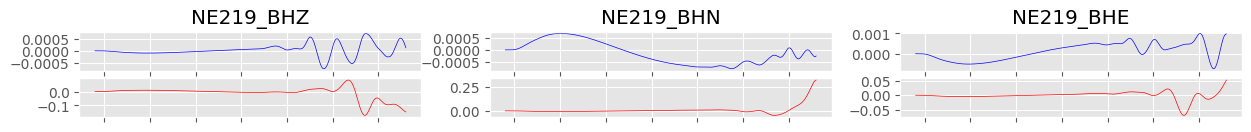

In [114]:
Model_037 = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.01
fmax = 0.2
#Model_062
plot_model(Model_037, idst, net, List,starttime)

##### [0.05 - 0.2]

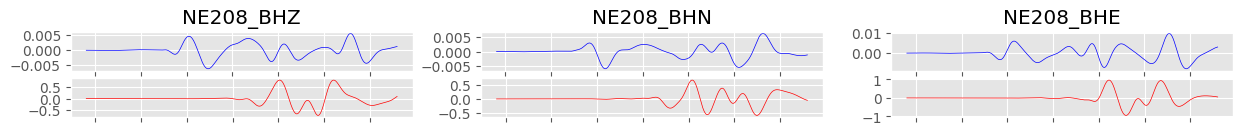

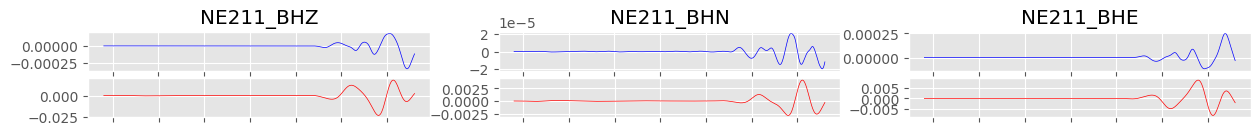

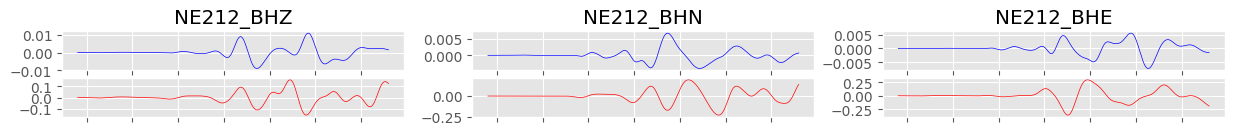

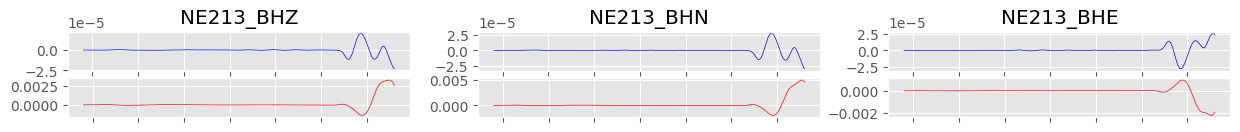

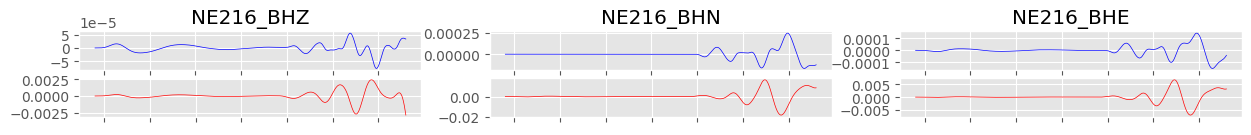

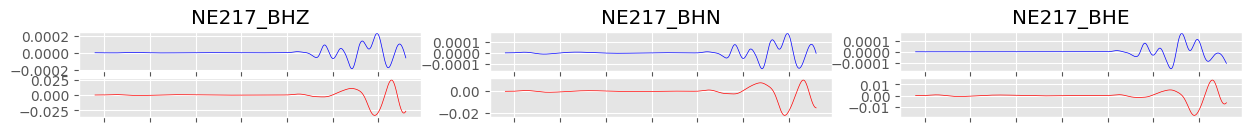

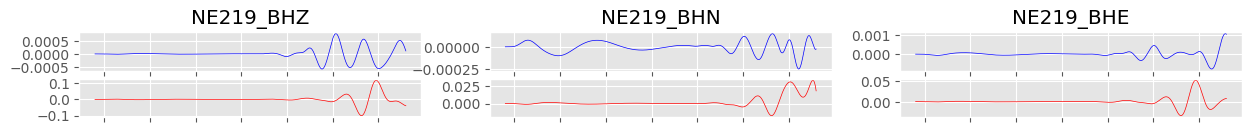

In [115]:
Model_037 = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.05
fmax = 0.2
#Model_062
plot_model(Model_037, idst, net, List,starttime)

##### [0.1 - 0.2]

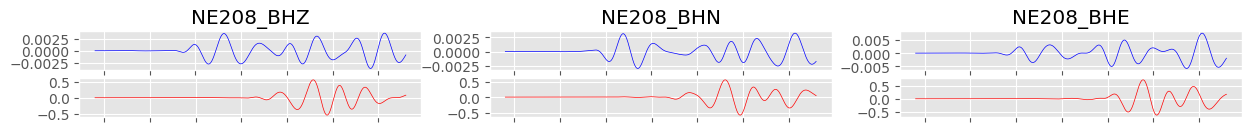

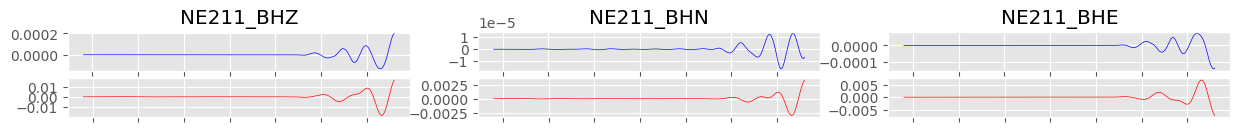

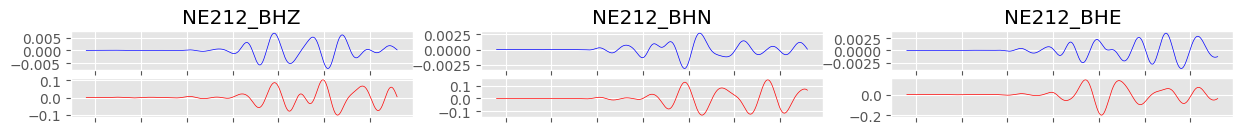

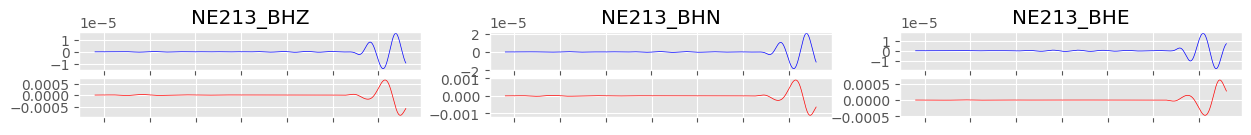

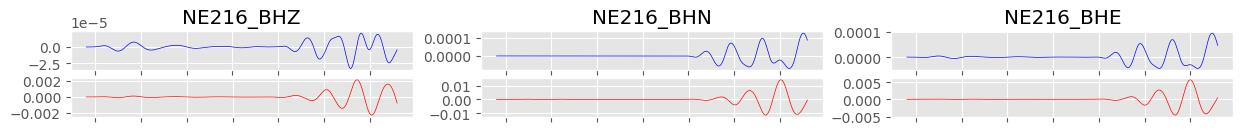

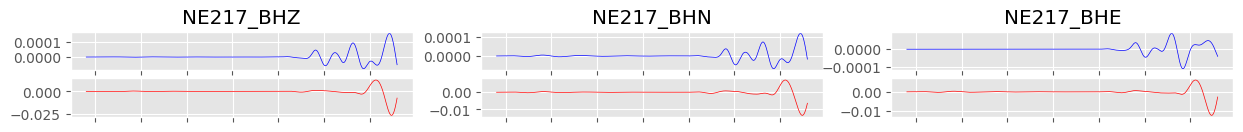

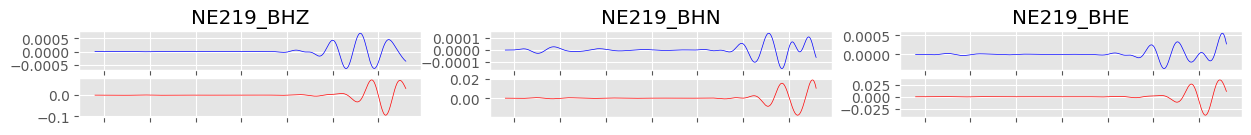

In [117]:
Model_037 = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.1
fmax = 0.2
#Model_062
plot_model(Model_037, idst, net, List,starttime)

##### [0.1 - 0.2]

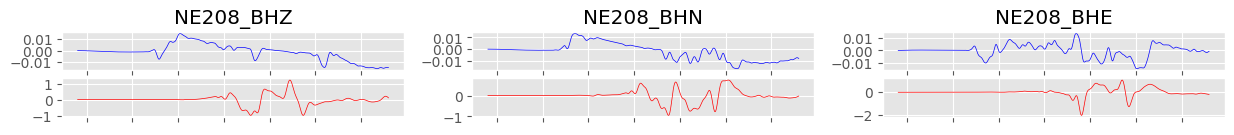

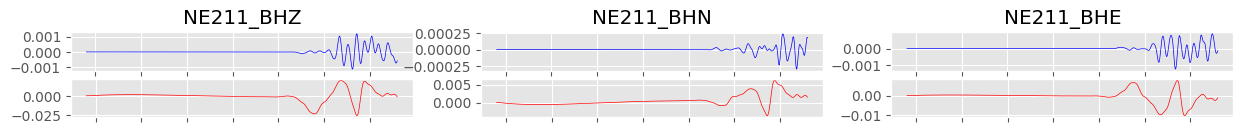

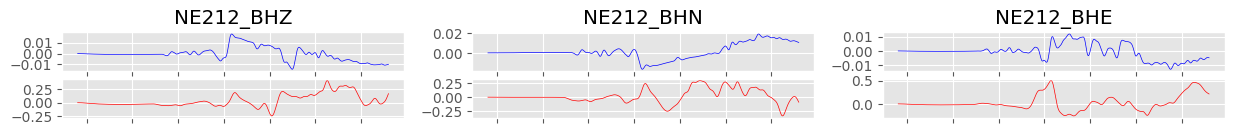

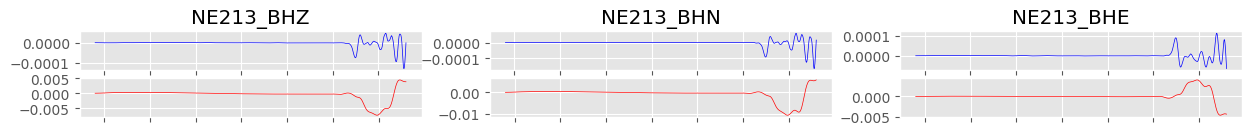

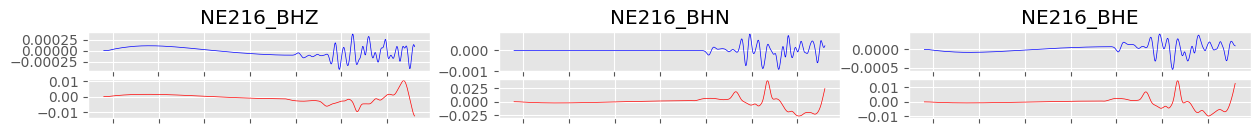

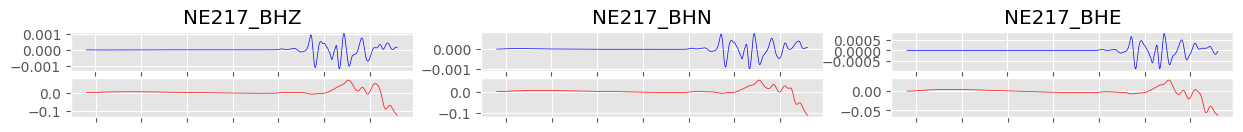

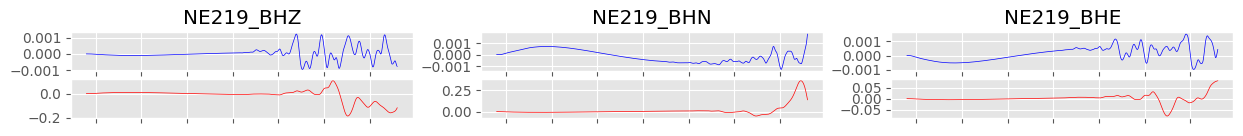

In [118]:
Model_037 = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.01
fmax = 0.6
#Model_062
plot_model(Model_037, idst, net, List,starttime)

##### [0.4 - 0.5]

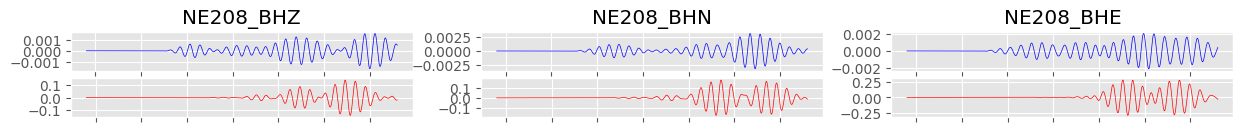

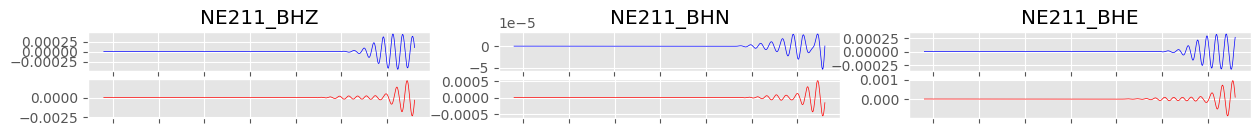

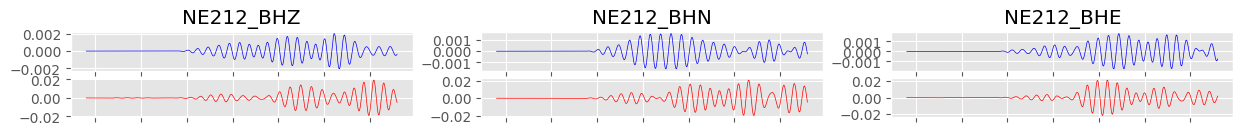

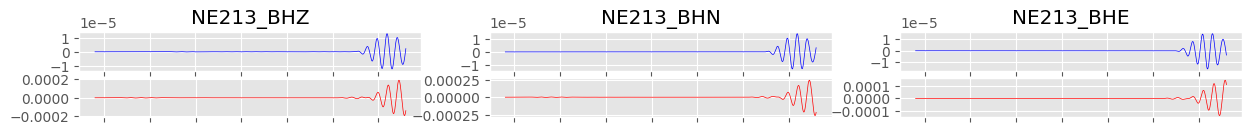

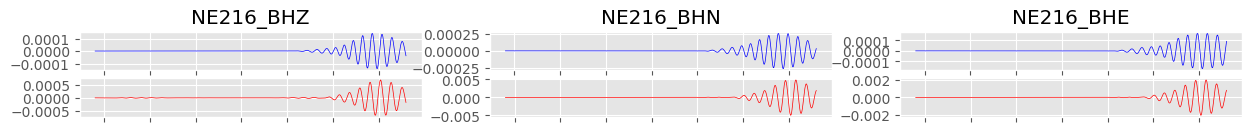

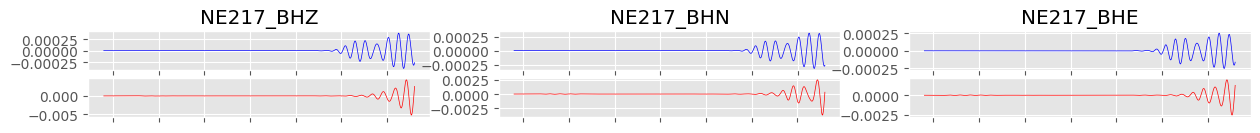

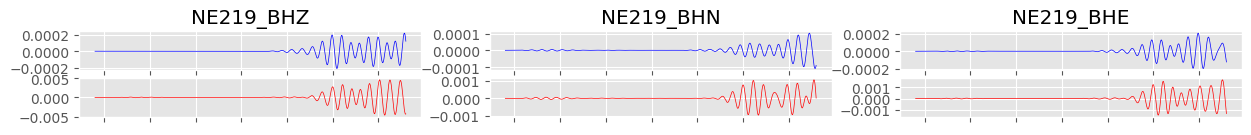

In [119]:
Model_037 = "../syn/model_037_1200km"
starttime = UTCDateTime(2017, 4, 3, 17, 40, 18)
idst = [3,5,6,7,8,9,11]
net = "NR"
List = ["NE208","NE211", "NE212", "NE213", "NE216","NE217","NE219"]
#butter filter
cor = 4
fmin = 0.4
fmax = 0.5
#Model_062
plot_model(Model_037, idst, net, List,starttime)